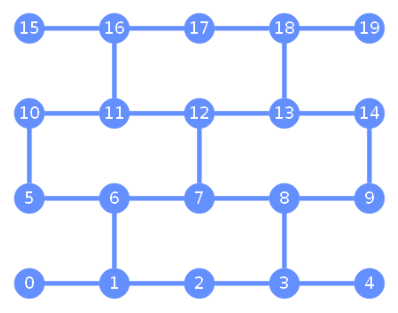

In [1]:
%load_ext autoreload
%autoreload 2

from qiskit_ibm_runtime.fake_provider import FakeBoeblingenV2
from qiskit.visualization import plot_gate_map

backend = FakeBoeblingenV2()

plot_gate_map(backend)

In [4]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator
from qiskit.providers.fake_provider import GenericBackendV2
from matplotlib import pyplot as plt
import sys
import numpy as np
from qiskit.quantum_info import Pauli
from qiskit_aer.noise import NoiseModel, pauli_error

sys.path.append("../../pauli_lindblad_per/")
from tomography.experiment import SparsePauliTomographyExperiment as tomography

plt.style.use("ggplot")

In [5]:
inst_map = [0,1,2,3]
n = 4
qc = QuantumCircuit(n)
qc.cx(1,2)
print(qc.draw())


errorops = [Pauli("XY"), Pauli('IZ')]
errorprobs = [0.02, 0.1]

# Erzeuge PauliError und NoiseModel
twoqubit_error = pauli_error([(op, p) for op, p in zip(errorops, errorprobs)] + [(Pauli("II"), 1 - sum(errorprobs))])
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx'])

connectivity = backend.coupling_map.graph.subgraph(inst_map)
backend._sim = AerSimulator(noise_model=noise_model)

          
q_0: ─────
          
q_1: ──■──
     ┌─┴─┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          


In [6]:
experiment = tomography(
    circuits = [qc], #list of circuits from which to get the layers requiring tomography
    inst_map = inst_map, #which physical qubits on the processor to map the qubits in the circuit
    backend = backend, #quantum backend
    used_qubits=[0,1,2,3]
    )

experiment.generate(
    samples = 100, #Number of samples to take from the fidelity pair measurements
    single_samples = 250, #samples to take from the pair-breaking measurements
    depths = [2,4,16,32,64] #values of 2n to make the pair measurements. Numbers must be even and non-zero
    )

shots = 1024
def executor(circuits):
    return backend.run(circuits, shots = shots, noise_model=noise_model).result().get_counts()

#run the experiment
experiment.run(executor)

c:\Users\kchar\OneDrive\Desktop\Uni\Hiwi_Orth\Qiskit\qiskit-venv\lib\site-packages\qiskit\compiler\transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(
c:\Users\kchar\OneDrive\Desktop\Uni\Hiwi_Orth\Qiskit\qiskit-venv\lib\site-packages\qiskit\compiler\transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(


In [7]:
noisedataframe = experiment.analyze()

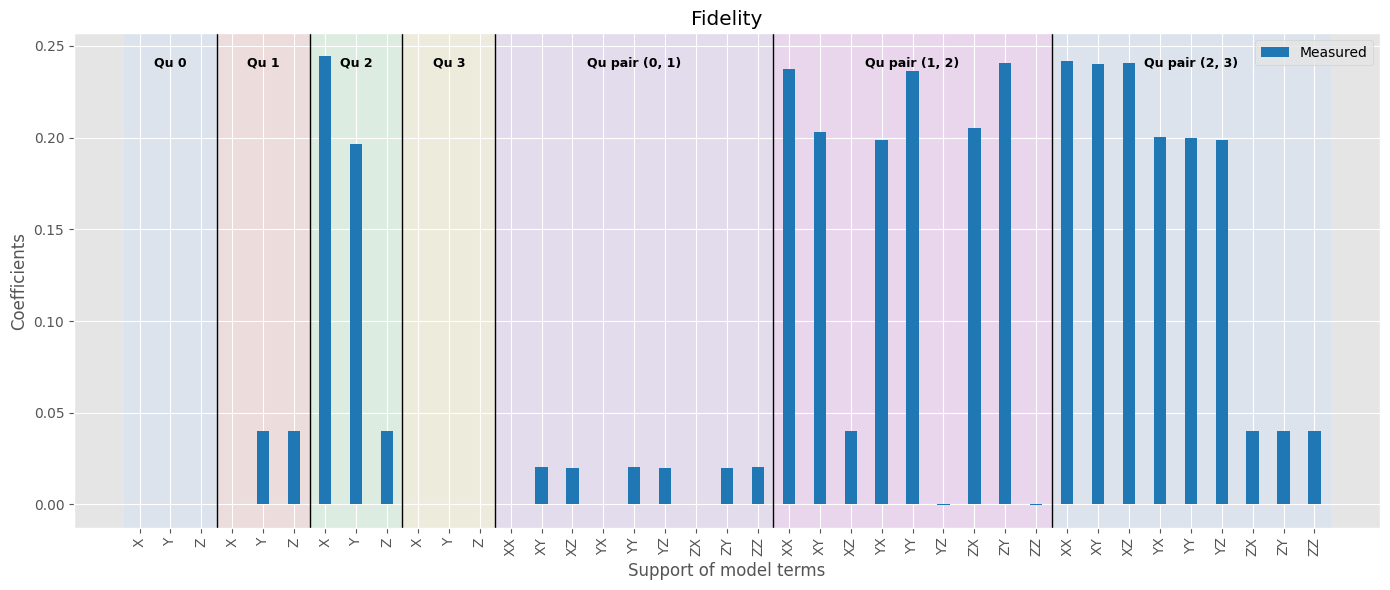

In [8]:
layer = experiment.analysis.get_layer_data(0)
layer.plot_infidelitites(plot_style = 2)

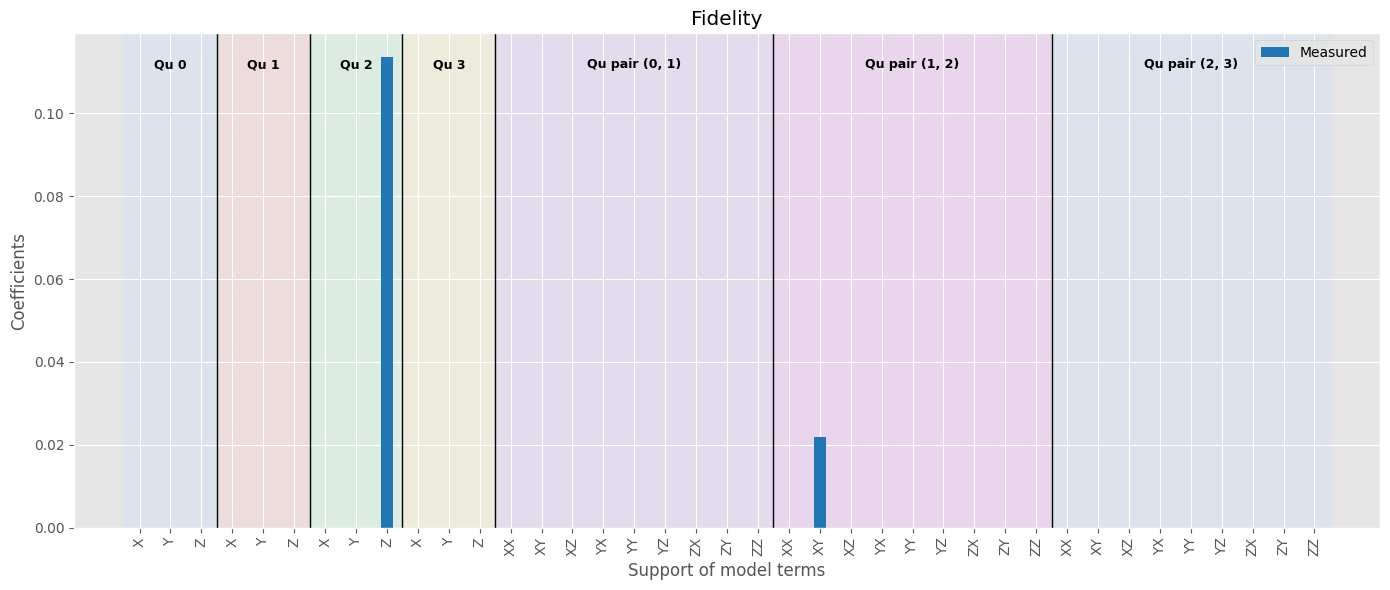

In [9]:
layer.plot_coeffs(plot_style = 2)